# Property Orientation Prediction with Neural Networks

This notebook demonstrates how to train a neural network to predict property orientations using the parameters we extracted from the geometric data. We'll use the Keras library to build, train, and evaluate our model.

## Workflow:
1. Import required libraries
2. Load and preprocess the orientation parameters data
3. Split data into training (80%) and testing (20%) sets
4. Build a neural network model
5. Train the model
6. Evaluate performance
7. Visualize results

## 1. Import Required Libraries

In [1]:
# Import libraries for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



In [2]:
# Neural network libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 2. Load and Preprocess Data

Let's load the orientation parameters data we created and prepare it for training.

In [3]:
# Load the data from the CSV file
from pathlib import Path

# Define the path to the data file
data_path = Path.cwd() / 'output' / 'orientation_nn_parameters.csv'

# Load the data
df = pd.read_csv(data_path)

# Display the first few rows
print(f"Loaded {len(df)} rows of data")
df.head()

Loaded 1198 rows of data


,address,suburb,postcode,state,orientation,gnaf_pid,property_centroid_x,property_centroid_y,property_area,property_perimeter,nearest_point_x,nearest_point_y,angle_to_road,road_id,distance_to_road
0,Unknown Address (ID: 0),NaN,NaN,NaN,South,NaN,334993.095966,6.259184e+06,346084.886387,4735.011388,334897.731689,6.258907e+06,-109.014329,19,0.000000
1,83A SUGARLOAF CRESCENT,CASTLECRAG,2068.0,NSW,South,GANSW704366658,334413.055817,6.259070e+06,1675.392805,291.650430,334411.971637,6.259067e+06,-107.307189,3,0.000000
2,81 SUGARLOAF CRESCENT,CASTLECRAG,2068.0,NSW,Southwest,GANSW704366657,334389.462989,6.259059e+06,1982.209750,313.168981,334389.331290,6.259059e+06,-123.780223,3,0.000000
3,79 SUGARLOAF CRESCENT,CASTLECRAG,2068.0,NSW,Northeast,GANSW704366654,334397.608068,6.259042e+06,1684.396019,260.232383,334402.962859,6.259050e+06,57.037217,3,0.000000
4,106 SUGARLOAF CRESCENT,CASTLECRAG,2068.0,NSW,Southwest,GANSW704349170,334589.423074,6.258941e+06,992.374257,174.180357,334557.222881,6.258915e+06,-141.413392,22,10.199746


In [4]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
address                0
suburb                 1
postcode               1
state                  1
orientation            0
gnaf_pid               1
property_centroid_x    0
property_centroid_y    0
property_area          0
property_perimeter     0
nearest_point_x        0
nearest_point_y        0
angle_to_road          0
road_id                0
distance_to_road       0
dtype: int64


In [5]:
# Preprocess the data

# Get summary statistics
print("Data summary statistics:")
df.describe()

Data summary statistics:


,postcode,property_centroid_x,property_centroid_y,property_area,property_perimeter,nearest_point_x,nearest_point_y,angle_to_road,road_id,distance_to_road
count,1197.000000,1198.000000,1.198000e+03,1198.000000,1198.000000,1198.000000,1.198000e+03,1198.000000,1198.000000,1198.000000
mean,2067.987469,335081.210261,6.258512e+06,1428.660923,153.063240,335083.537367,6.258510e+06,-9.257239,70.455760,8.870014
std,0.250104,566.671230,2.489888e+02,10487.426226,172.213410,564.378097,2.477984e+02,99.221416,51.950905,14.186987
min,2063.000000,334273.230183,6.257961e+06,187.355116,60.109606,334261.826702,6.257977e+06,-179.594269,2.000000,0.000000
25%,2068.000000,334577.999150,6.258332e+06,595.931908,108.606465,334573.651340,6.258323e+06,-95.605259,22.000000,2.626892
50%,2068.000000,334992.081324,6.258514e+06,714.900603,119.885827,334981.981766,6.258521e+06,1.613971,54.000000,6.124429
75%,2068.000000,335515.369761,6.258681e+06,885.493854,139.103390,335512.948562,6.258683e+06,71.864952,120.500000,8.929799
max,2068.000000,336185.792250,6.259195e+06,346084.886387,4735.011388,336202.949913,6.259196e+06,179.402493,172.000000,160.077631


In [6]:
# Select features for the model
# We'll use the geometric parameters for prediction
feature_cols = [
    'property_centroid_x', 'property_centroid_y', 
    'property_area', 'property_perimeter',
    'nearest_point_x', 'nearest_point_y', 
    'angle_to_road', 'distance_to_road'
]

# Handle missing values (if any)
for col in feature_cols:
    if col in df.columns:
        # Replace NaN values with mean for numerical columns
        df[col] = df[col].fillna(df[col].mean())

# The target variable is 'orientation'
# Check unique orientation values
print("Unique orientation values:")
print(df['orientation'].value_counts())

# Encode the target variable (orientation)
label_encoder = LabelEncoder()
df['orientation_encoded'] = label_encoder.fit_transform(df['orientation'])

# Display the encoding mapping
print("\nOrientation encoding mapping:")
for i, orientation in enumerate(label_encoder.classes_):
    print(f"{orientation}: {i}")

# Prepare features and target
X = df[feature_cols]
y = df['orientation_encoded']

# One-hot encode the target for neural network training
y_onehot = keras.utils.to_categorical(y)

Unique orientation values:
orientation
East         201
South        196
North        156
Southwest    149
West         133
Northeast    131
Northwest    122
Southeast    110
Name: count, dtype: int64

Orientation encoding mapping:
East: 0
North: 1
Northeast: 2
Northwest: 3
South: 4
Southeast: 5
Southwest: 6
West: 7


## 3. Split Data into Train and Test Sets

We'll split our data into training (80%) and testing (20%) sets.

In [7]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, test_size=0.2, random_state=42, stratify=y
)

# Apply feature scaling for better convergence
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Testing set shape: {X_test_scaled.shape}")

# Check the distribution of classes in training and testing sets
print("\nClass distribution in original dataset:")
print(pd.Series(y).value_counts(normalize=True).sort_index() * 100)

print("\nClass distribution in training set:")
print(pd.Series(np.argmax(y_train, axis=1)).value_counts(normalize=True).sort_index() * 100)

Training set shape: (958, 8)
Testing set shape: (240, 8)

Class distribution in original dataset:
orientation_encoded
0    16.777963
1    13.021703
2    10.934891
3    10.183639
4    16.360601
5     9.181970
6    12.437396
7    11.101836
Name: proportion, dtype: float64

Class distribution in training set:
0    16.805846
1    13.048017
2    10.960334
3    10.125261
4    16.388309
5     9.185804
6    12.421712
7    11.064718
Name: proportion, dtype: float64


## 4. Build Neural Network Model

We'll build a neural network model using Keras to predict property orientations.

In [8]:
# Define the number of input features and output classes
input_dim = X_train_scaled.shape[1]  # Number of features
num_classes = y_train.shape[1]  # Number of orientation classes

# Build the neural network model
model = keras.Sequential([
    # Input layer
    layers.Input(shape=(input_dim,)),
    
    # Hidden layers
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    # Output layer - softmax for multi-class classification
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304 (12.91 KB)

 Trainable params: 3,112 (12.16 KB)

 Non-trainable params: 192 (768.00 B)

## 5. Train the Model

Now we'll train the neural network on our training data.

In [9]:
# Set up callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

checkpoint_path = "orientation_model_checkpoint.keras"
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model
epochs = 100
batch_size = 32

history = model.fit(
    X_train_scaled, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,  # 20% of training data used for validation
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1361 - loss: 2.6256
Epoch 1: val_loss improved from None to 1.98226, saving model to orientation_model_checkpoint.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.1749 - loss: 2.3998 - val_accuracy: 0.2969 - val_loss: 1.9823
Epoch 2/100
15/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2933 - loss: 2.0086 
Epoch 2: val_loss improved from 1.98226 to 1.86244, saving model to orientation_model_checkpoint.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3159 - loss: 1.9131 - val_accuracy: 0.4375 - val_loss: 1.8624
Epoch 3/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3534 - loss: 1.8618 
Epoch 3: val_loss improved from 1.86244 to 1.76029, saving model to orientation_model_checkpoint.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3695 - loss: 1.7430 - val_accuracy: 0.5417 - val_loss: 1.7603
Epoch 4/100
16/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3943 - loss: 1.6138 
Epo

## 6. Evaluate Model Performance

Let's evaluate how well our model performs on the test data.

In [10]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"\nTest accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Make predictions on the test set
y_pred_prob = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate classification report
print("\nClassification Report:")
print(classification_report(
    y_true, 
    y_pred, 
    target_names=label_encoder.classes_
))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9125 - loss: 0.9890  

Test accuracy: 0.9125
Test loss: 0.9890
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Classification Report:
              precision    recall  f1-score   support

        East       0.93      0.97      0.95        40
       North       0.94      0.94      0.94        31
   Northeast       1.00      0.92      0.96        26
   Northwest       0.88      0.88      0.88        25
       South       0.88      0.97      0.93        39
   Southeast       0.95      0.86      0.90        22
   Southwest       0.92      0.80      0.86        30
        West       0.83      0.89      0.86        27

    accuracy                           0.91       240
   macro avg       0.92      0.91      0.91       240
weighted avg       0.91      0.91      0.91       240



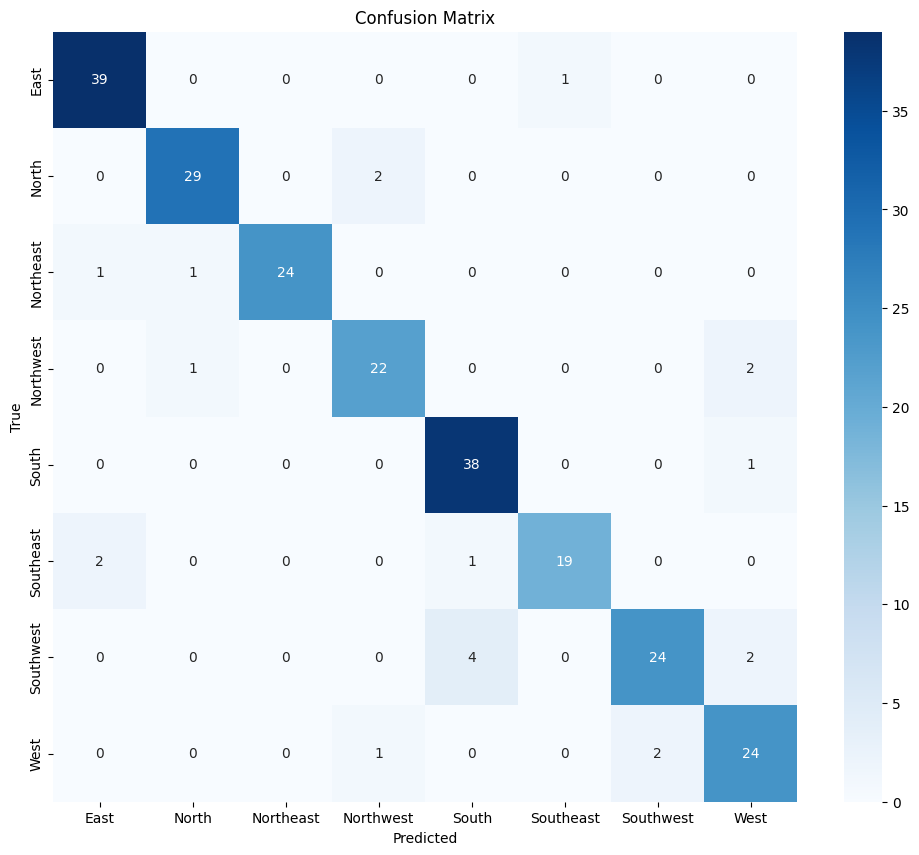


Per-class accuracy:
  Orientation  Accuracy
0        East  0.975000
4       South  0.974359
1       North  0.935484
2   Northeast  0.923077
7        West  0.888889
3   Northwest  0.880000
5   Southeast  0.863636
6   Southwest  0.800000


In [11]:
# Compute and display confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate per-class accuracy
per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
accuracy_df = pd.DataFrame({
    'Orientation': label_encoder.classes_,
    'Accuracy': per_class_accuracy
})
print("\nPer-class accuracy:")
print(accuracy_df.sort_values('Accuracy', ascending=False))

## 7. Visualize Results

Let's visualize the training process and model performance.

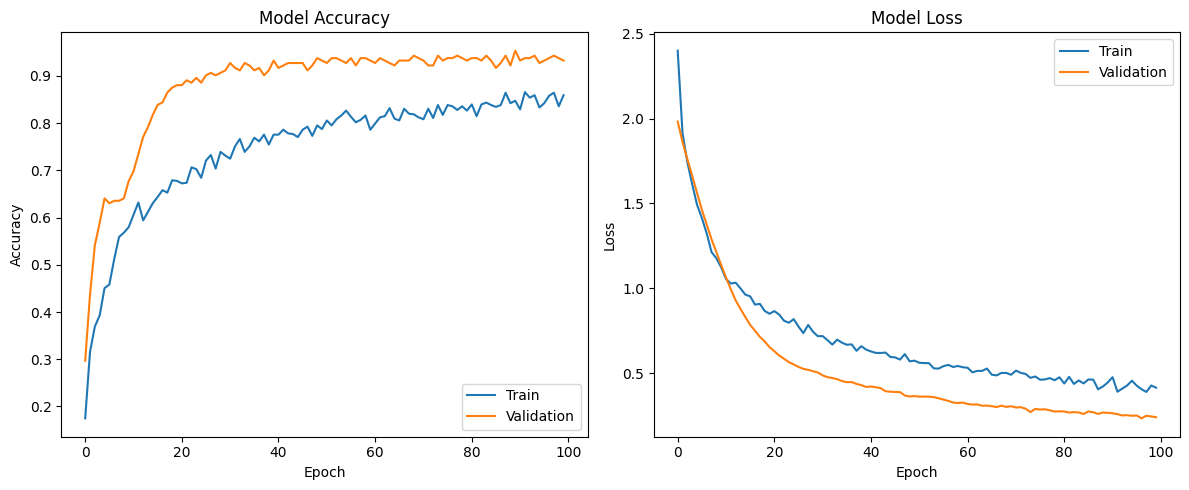

In [12]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

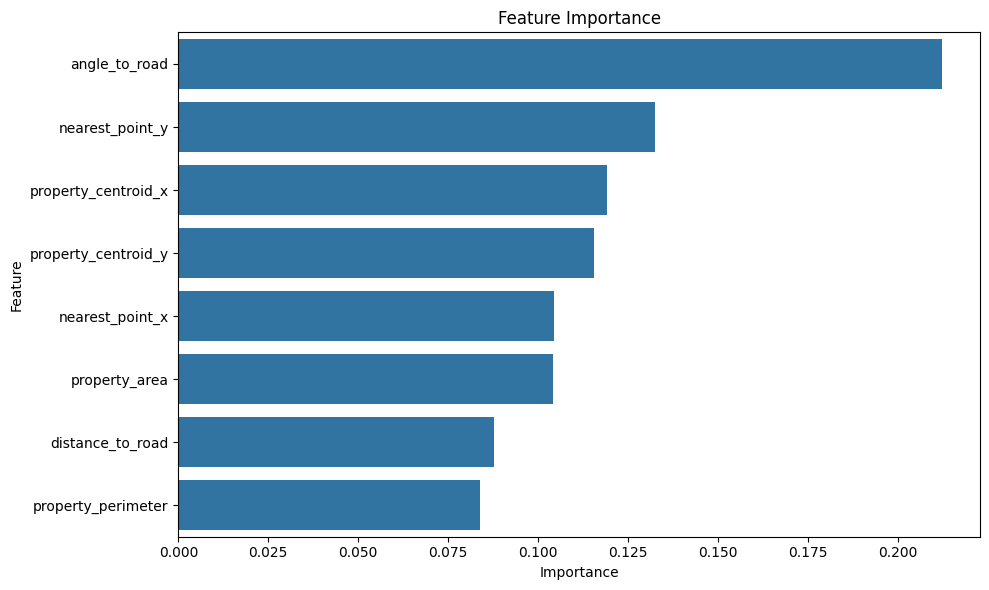

Feature importance:
               Feature  Importance
6        angle_to_road    0.212317
5      nearest_point_y    0.132567
0  property_centroid_x    0.119206
1  property_centroid_y    0.115690
4      nearest_point_x    0.104535
2        property_area    0.104285
7     distance_to_road    0.087647
3   property_perimeter    0.083789


In [13]:
# Visualize feature importance
# We'll use a simple approach based on the weights of the first layer

# Get weights from the first layer
first_layer_weights = model.layers[0].get_weights()[0]

# Calculate absolute importance by taking the average of absolute weights for each feature
feature_importance = np.mean(np.abs(first_layer_weights), axis=1)
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

# Sort by importance
features_df = features_df.sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features_df)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# Print feature importance
print("Feature importance:")
print(features_df)

In [14]:
# Save the model
model.save("property_orientation_model.keras")
print("Model saved to 'property_orientation_model.keras'")

# Example of how to use the model for predictions
def predict_orientation(property_data):
    """
    Make predictions with the trained model
    
    Args:
        property_data: A dictionary with the geometric parameters
                       matching the feature columns
    
    Returns:
        Predicted orientation and confidence
    """
    # Create a dataframe with the input data
    input_df = pd.DataFrame([property_data])
    
    # Apply the same scaling as during training
    input_scaled = scaler.transform(input_df)
    
    # Make prediction
    prediction = model.predict(input_scaled)[0]
    
    # Get the predicted class and confidence
    predicted_class_idx = np.argmax(prediction)
    confidence = prediction[predicted_class_idx]
    predicted_orientation = label_encoder.inverse_transform([predicted_class_idx])[0]
    
    return predicted_orientation, confidence

# Example property data
example_property = {
    'property_centroid_x': X.iloc[0]['property_centroid_x'],
    'property_centroid_y': X.iloc[0]['property_centroid_y'],
    'property_area': X.iloc[0]['property_area'],
    'property_perimeter': X.iloc[0]['property_perimeter'],
    'nearest_point_x': X.iloc[0]['nearest_point_x'],
    'nearest_point_y': X.iloc[0]['nearest_point_y'],
    'angle_to_road': X.iloc[0]['angle_to_road'],
    'distance_to_road': X.iloc[0]['distance_to_road']
}

# Make prediction
orientation, confidence = predict_orientation(example_property)
print(f"\nExample prediction: {orientation} with {confidence:.2%} confidence")

Model saved to 'property_orientation_model.keras'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Example prediction: West with 100.00% confidence


## Conclusion

In this notebook, we've:

1. Loaded the property orientation parameters data
2. Preprocessed the data by handling missing values and encoding the orientation labels
3. Split the data into training (80%) and testing (20%) sets
4. Built a neural network model using Keras
5. Trained the model with early stopping to prevent overfitting
6. Evaluated the model's performance on the test set
7. Visualized the results and feature importance
